In [1]:
from dotenv import load_dotenv

load_dotenv()

from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma


In [3]:
import pickle

with open("chunks.pkl", "rb") as f:
    chunks = pickle.load(f)


In [59]:
docs=chunks

In [90]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")


d:\Tasks 2024\Advanced Rag System for Building Managers\Code\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\afiniti\.cache\huggingface\hub\models--BAAI--bge-base-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [94]:
db = None
retriever = None
import shutil

shutil.rmtree("chroma_store", ignore_errors=True)  # or your actual directory name



In [129]:
from langchain_community.vectorstores import Chroma

db = Chroma.from_documents(docs, embedding=embedder,persist_directory="chroma_store")
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 10})


In [130]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# Set up Gemini (gpt-4o equivalent from Google)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.2)

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

rag_chain = prompt | llm


In [3]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI


class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage


class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        #llm = ChatOpenAI(model="gpt-4o-mini")
        llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state

def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content=""" You are a classifier that determines whether a user's question is about one of the following topics 
    
    
    1. Building Manager Team  
    2. Learning Outcomes and Objectives  
    3. Dress Code  
    4. Management Hierarchy  
    5. Who Ya Gonna Call?  
    6. Shift Scheduling  
    7. Find a Cover/Trade  
    8. Discipline  
    9. Shift Reports  
    10. Shift Change Chats  
    11. Radio Etiquette  
    12. Timesheet Edits Form  
    13. The Event Schedule  
    14. 7Point Ops  
    15. Set Up Notes  
    16. Determining AV Needs  
    17. Function Housekeeper Info  
    18. Building Rounds  
    19. Locking Rooms  
    20. Opening and Closing the Buildings  
    21. Opening Checklist  
    22. Closing Checklist  
    23. Mandel Hall Closing  
    24. Which Spaces Are Open to the Public  
    25. Building Access and Double Tap  
    26. Building Partners  
    27. Managing Client Reservations  
    28. Notes for RSO Events  
    29. Notes for Departmental and External Events  
    30. Audio Visual Equipment and Set Ups  
    31. Loaning Out Miscellaneous Items  
    32. Keys  
    33. Moving Furniture  
    34. Furniture Storage Locations  
    35. Managing and Requesting Custodial/Maintenance Services  
    36. Function Housekeeper  
    37. The Mail  
    38. Packages at Ida Noyes  
    39. Lost and Found  
    40. Answering the Phone(s)  
    41. Transferring Calls  Reynolds Club  
    42. Transferring Calls Ida Noyes Hall  
    43. Emergency Procedures  
    44. Troubleshooting  
    45. Appendices  Key Lists  
    46. General Shift Expectation Cheat Sheet  
    47. Campus Resources
    48. Desk Expectations 
    49. Workday
    50. Fire Safety
    60. Children and Family Services
    61. Building Manager Dress Code
    
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    #llm = ChatOpenAI(model="gpt-4o")
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    #state["on_topic"] = result.score.strip()
    state["on_topic"] = 'Yes'
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state


class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )

def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    #llm = ChatOpenAI(model="gpt-4o")
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 5:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"
    
def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    #llm = ChatOpenAI(model="gpt-4o")
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state

def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(
        AIMessage(
            content="I'm sorry, but I cannot find the information you're looking for."
        )
    )
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state

d:\Tasks 2024\Advanced Rag System for Building Managers\Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
!where python

d:\Tasks 2024\Advanced Rag System for Building Managers\Code\.venv\Scripts\python.exe
C:\Python313\python.exe
C:\Users\afiniti\AppData\Local\Microsoft\WindowsApps\python.exe


In [132]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [133]:
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)
workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)

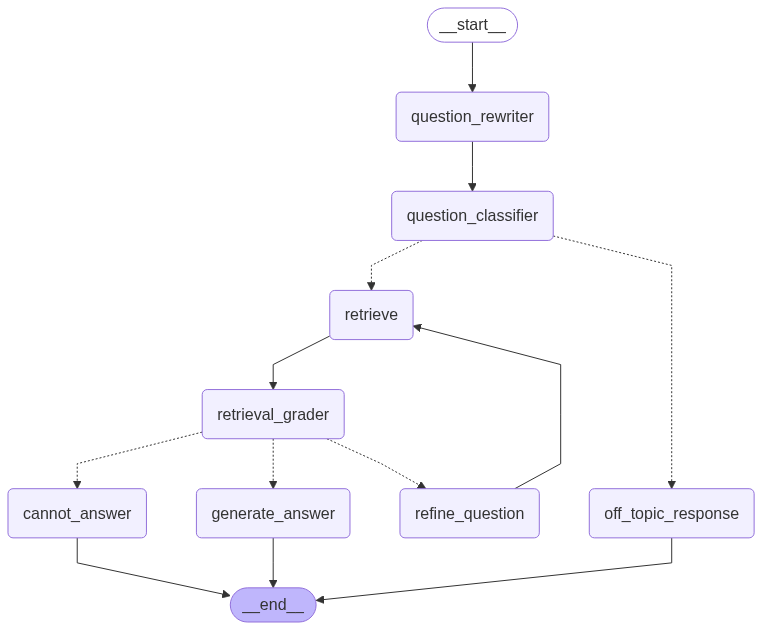

In [134]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [135]:
# input_data = {"question": HumanMessage(content="What does the company Apple do?")}
# graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})


In [136]:
input_data = {"question": HumanMessage(content="How do I contact Lilly?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})


Entering question_rewriter with following state: {'question': HumanMessage(content='How do I contact Lilly?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 10 documents
Entering retrieval_grader
Grading document: your shift report that you sub... Result: Yes
Grading document: your shift report that you sub... Result: Yes
Grading document: Shoshi Spurlock - 617-388-7778... Result: Yes
Grading document: o If Lilly does not answer, co... Result: Yes
Grading document: Who Should I Call? 
All of the... Result: Yes
Grading document: do
 
not
 
know
 
who
 
to
 
s... Result: No
Grading document: Reynolds
 
Club)
 ○  Ask  them... Result: No
Grading document: give
 
out
 
event
 
organizer... Result: No
Grading document: ask,
 
please
 
put
 
it
 
in
... Result: No
Grading document: and
 
ask
 
them
 
to
 
call
 ... Result: No
retrieval_grader: proce

{'messages': [HumanMessage(content='How do I contact Lilly?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='To contact Lilly, call 651-605-1458.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'page_label': '1', 'source': 'WhoShouldIcall.pdf', 'total_pages': 2, 'creationdate': '2025-06-04T16:56:14-05:00', 'moddate': '2025-06-04T16:56:14-05:00', 'creator': 'Microsoft® Word for Microsoft 365', 'producer': 'Microsoft® Word for Microsoft 365', 'page': 0, 'author': 'Jazil Kalim'}, page_content='your shift report that you submitted a work order. \nIf you are running late or experiencing an emergency please contact Lilly: \nLilly Gullickson - 651-605-1458 \nIf the building is experiencing an emergency, please contact Lilly after you have contacted \n911. \nIf Lilly does not respond and your issue is urgent, please contact Shoshi: \nShoshi Spurlock - 617-388-7778'),
  Document(metadata={'source': 'WhoShouldIcall.pdf', 'creator': 'Microsoft®

In [104]:
input_data = {"question": HumanMessage(content="What does the key AA42 do?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})


Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})], 'documents': [Document(metadata={'producer': 'Skia/PDF m135 Google Docs Renderer', 'source': 'Building_Manager_Handbook.pdf', 'creationdate': '', 'title': 'Building Manager Handbook', 'page': 6, 'page_label': '7', 'creator': 'PyPDF', 'total_pages': 34}, page_content='notes\n \nfor\n \nthat\n \nevent.\n \nThere\n \nwill\n \nbe\n \n(2)\n \nindicators\n \n–\n \nthe\n \n“AV\n \ninventory”\n \nand\n \nthe\n \n“**A/V**”.\n ■  AV  Inventory  ●  •The  AV  inventory  is  a  list  of  what  AV  is  needed  for  the  event.  ■  •**A/V**'), Document(metadata={'page_label': '1', 'author': 'Jazil Kalim', 'creator': 'Microsoft® Word for Microsoft 365', 'total_pages': 1, 'moddate': '2025-06-04T16:57:39-05:00', 'page': 0, 'creationdate': '2025-06-04T16:57:39-05:00', 'producer': 'Microsoft® Word for Microsoft 365', 'source': 'Desk_Expectatio

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
}
].


Grading document: officer’s  name  and  badge  n... Result: No


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 58
}
]

In [107]:
input_data = {"question": HumanMessage(content="What are the general shift expectations?")}
response=graph.invoke(input=input_data, config={"configurable": {"thread_id": 4}})


Entering question_rewriter with following state: {'messages': [HumanMessage(content='What are the general shift expectations?', additional_kwargs={}, response_metadata={}), AIMessage(content='Based on the provided text, general shift expectations include treating all shifts the same, even busy ones.  If an important call is expected, employees should consult with ADOPs or ADBS to arrange brief coverage.  New hires have access to shadowing shifts, but existing employees should not pick them up.', additional_kwargs={}, response_metadata={})], 'documents': [Document(metadata={'producer': 'Skia/PDF m135 Google Docs Renderer', 'page': 2, 'creationdate': '', 'total_pages': 34, 'source': 'Building_Manager_Handbook.pdf', 'title': 'Building Manager Handbook', 'creator': 'PyPDF', 'page_label': '3'}, page_content='up\n \non\n \na\n \nparticularly\n \nbusy\n \nday.\n \nTreat\n \nthese\n \nshifts\n \nthe\n \nsame\n \nas\n \nany\n \nother.\n ●  Shadowing  shifts :  these  shifts  are  for  new  hire

In [123]:
input_data = {"question": HumanMessage(content="Can you check if Claire works at career advancement?")}
response=graph.invoke(input=input_data, config={"configurable": {"thread_id": 8}})
print(response['messages'][1].content)


Entering question_rewriter with following state: {'question': HumanMessage(content='Can you check if Claire works at career advancement?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader
Grading document: 'Description': 'Career Advance... Result: No
Grading document: Staff Directory'}, {'Name': 'C... Result: Yes
Grading document: Check  in  with  SC  Staff  
C... Result: No
Grading document: please
 
search
 
for
 
the
 
... Result: No
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: Yes, based on the provided data, Claire Silcox works at Career Advancement.
Yes, based on the provided data, Claire Silcox works at Career Advancement.


In [124]:
input_data = {"question": HumanMessage(content="Can you check if Jazil works at career advancement?")}
response=graph.invoke(input=input_data, config={"configurable": {"thread_id": 9}})
print(response['messages'][1].content)


Entering question_rewriter with following state: {'question': HumanMessage(content='Can you check if Jazil works at career advancement?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader
Grading document: 'Description': 'Career Advance... Result: No
Grading document: [{'Name': 'Alyssa Nelson', 'E-... Result: No
Grading document: Check  in  with  SC  Staff  
C... Result: No
Grading document: There
 
will
 
be
 
times
 
on... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: Does Jazil work in career advancement?
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader
Grading document: Directory'}, {'Name': 'Liz Sch... Result: No
Grading document: 'Description': 'Career Adv

In [125]:
input_data = {"question": HumanMessage(content="What does the key number 19AA do?")}
response=graph.invoke(input=input_data, config={"configurable": {"thread_id": 10}})
print(response['messages'][1].content)


Entering question_rewriter with following state: {'question': HumanMessage(content='What does the key number 19AA do?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader
Grading document: when
 
on
 
an
 
active
 
call... Result: No
Grading document: SKD5  AV  Closets  DX  Library... Result: Yes
Grading document: notes
 
for
 
that
 
event.
 
... Result: No
Grading document: give
 
out
 
keys
 
to
 
anyon... Result: No
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: Based on the provided text, key number 19AA provides access to the Old West Lounge Projector Box.
Based on the provided text, key number 19AA provides access to the Old West Lounge Projector Box.


In [ ]:
input_data = {"question": HumanMessage(content="What is the dress code for building managers?")}
response=graph.invoke(input=input_data, config={"configurable": {"thread_id": 11}})
print(response['messages'][1].content)


Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the key number 19AA do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Based on the provided text, key number 19AA provides access to the Old West Lounge Projector Box.', additional_kwargs={}, response_metadata={})], 'documents': [Document(metadata={'total_pages': 34, 'page': 30, 'title': 'Building Manager Handbook', 'page_label': '31', 'creator': 'PyPDF', 'producer': 'Skia/PDF m135 Google Docs Renderer', 'creationdate': '', 'source': 'Building_Manager_Handbook.pdf'}, page_content='SKD5  AV  Closets  DX  Library  Door  Alarm  C415A  Podiums  Tree  Key  Front  Desk  cabinets  2ED89  012  AH2  Cinema  Side  Door  Alarm  D018  Trash  Compactor  19AA  Old  West  Lounge  Projector  Box  19DD  West  Lounge  Projector  Box  Master  Master  Padlock  on  the  Front  Desk  Cabinet  82270  Master  Access  Code  to  Keypad  Doors  Small  Gold  Key  ADA  lifts   RC  Keys Key  Access')],

In [137]:
input_data = {"question": HumanMessage(content="What to do in case of medical emergency and who to contact?")}
response=graph.invoke(input=input_data, config={"configurable": {"thread_id": 13}})
print(response['messages'][1].content)


Entering question_rewriter with following state: {'question': HumanMessage(content='What to do in case of medical emergency and who to contact?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 10 documents
Entering retrieval_grader
Grading document: Call  for  an  ambulance  if  ... Result: Yes
Grading document: Someone  needs  medical  atten... Result: Yes
Grading document: out
 
to
 
one
 
of
 
the
 
Le... Result: Yes
Grading document: Emergency  Description  of  Du... Result: No
Grading document: questions.
 
In
 
an
 
obvious... Result: Yes
Grading document: like
 
a
 
pipe
 
burst,
 
etc... Result: No
Grading document: Shoshi Spurlock - 617-388-7778... Result: Yes
Grading document: they  were  called,  and  ask ... Result: No
Grading document: with  the  person  and  provid... Result: Yes
Grading document: Alternatives  to  calling  UCP.